In [1]:

import warnings
import pandas as pd
from utils.Copernicus import AdvancedCopernicus
import datetime
import os
import xarray as xr
from tqdm import tqdm
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

/home/marco/venv/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
ds = xr.open_dataset('data/NO_TS_TG_KielHoltenauTG.nc')
ds

<xarray.Dataset> Size: 17MB
Dimensions:    (TIME: 1018869, DEPTH: 1)
Coordinates:
  * TIME       (TIME) datetime64[ns] 8MB 2014-01-19T06:00:00 ... 2025-02-28T2...
    DEPH       (DEPTH) float32 4B ...
    LATITUDE   float32 4B ...
    LONGITUDE  float32 4B ...
    STATION    |S64 64B ...
Dimensions without coordinates: DEPTH
Data variables:
    TIME_QC    (TIME) int8 1MB ...
    SLEV       (TIME, DEPTH) float32 4MB ...
    SLEV_QC    (TIME, DEPTH) float32 4MB ...
Attributes: (12/42)
    data_mode:                      R
    id:                             NO_TS_TG_KielHoltenauTG
    institution:                    Waterways and Shipping Authority Luebeck
    institution_country:            Germany
    institution_edmo_code:          2313
    naming_authority:               Copernicus Marine In Situ
    ...                             ...
    update_interval:                P1M
    date_modified:                  2025-03-03T07:42:30Z
    date_created:                   2025-03-03T07:42:30Z
    history:                        2025-03-03T07:42:30Z : Creation
    last_date_observation:          2025-02-28T23:50:00Z
    bottom_depth:

In [9]:
filenames = os.listdir("data")
marinas = []
for file in filenames:
    if 'TG.nc' in file:
        marinas.append(file)
        

marinas

['NO_TS_TG_TeignbridgePierTG.nc',
 'NO_TS_TG_KeizersveerTG.nc',
 'NO_TS_TG_VardoeTG.nc',
 'NO_TS_TG_RoompotBuitenTG.nc',
 'NO_TS_TG_LeirvikTG.nc',
 'NO_TS_TG_BronsTG.nc',
 'NO_TS_TG_WittduenTG.nc',
 'NO_TS_TG_VlakteVdRaanTG.nc',
 'NO_TS_TG_NarvikTG.nc',
 'NO_TS_TG_RostockTG.nc',
 'NO_TS_TG_OudeSchildTG.nc',
 'NO_TS_TG_Haringvliet10TG.nc',
 'NO_TS_TG_AlthagenTG.nc',
 'NO_TS_TG_ArunPlatformTG.nc',
 'NO_TS_TG_HoutribsluizenNoordTG.nc',
 'NO_TS_TG_KoserowTG.nc',
 'NO_TS_TG_BergenTG.nc',
 'NO_TS_TG_SandownPierTG.nc',
 'NO_TS_TG_OsloTG.nc',
 'NO_TS_TG_TimmendorfPoelTG.nc',
 'NO_TS_TG_MaloyTG.nc',
 'NO_TS_TG_HonningsvaagTG.nc',
 'NO_TS_TG_Brouwershavensegat8TG.nc',
 'NO_TS_TG_KrabbersgatsluizenNoordTG.nc',
 'NO_TS_TG_WittowerFaehreTG.nc',
 'NO_TS_TG_HastingsPierTG.nc',
 'NO_TS_TG_StPauliTG.nc',
 'NO_TS_TG_EsbjergTG.nc',
 'NO_TS_TG_BorkumSudTG.nc',
 'NO_TS_TG_AWGTG.nc',
 'NO_TS_TG_FlensburgTG.nc',
 'NO_TS_TG_PortIsaacTG.nc',
 'NO_TS_TG_MondDerVechtTG.nc',
 'NO_TS_TG_HerneBayTG.nc',
 'NO_TS_TG_

In [10]:
START_DATE = '2025-01-01'
END_DATE = '2025-02-01'

df_all = pd.DataFrame()
for marinas in tqdm(marinas, desc='get Marinas'):
    f = os.path.join("data", marinas)
    ds = xr.open_dataset(f)
    df = ds.to_dataframe().reset_index()

    df['TIME'] = pd.to_datetime(df['TIME'])
    # Filter data from START_DATE and END_DATE
    df = df.loc[(df['TIME'] >= START_DATE) & (df['TIME'] <= END_DATE)]
    df = df[df['SLEV_QC'] == 1]

    df_all = pd.concat([df_all, df], axis=0)




df_marinas = pd.DataFrame()
for station in tqdm(df_all['STATION'].unique(), desc='make hourly'):
    df_station = df_all[df_all['STATION'] == station]

    # Group the Data hourly and take the mean
    df_hourly = df_station.copy()

    df_hourly.set_index('TIME', inplace=True)

    df_hourly = df_hourly.resample('h').mean(numeric_only=True)
    df_hourly['STATION'] = station
    df_hourly.reset_index(inplace=True)
    df_marinas = pd.concat([df_marinas, df_hourly], axis=0)




#df_marinas = df_marinas[df_marinas['TIME'] > START_DATE]

df_marinas['STATION'] = df_marinas['STATION'].astype(str)

make hourly: 100%|██████████| 167/167 [00:11<00:00, 14.45it/s]


In [15]:
df_marinas['STATION'].unique(), df_marinas['STATION'].nunique()

(array(['KeizersveerTG', 'VardoeTG', 'RoompotBuitenTG', 'LeirvikTG',
        'BronsTG', 'WittduenTG', 'VlakteVdRaanTG', 'NarvikTG', 'RostockTG',
        'OudeSchildTG', 'Haringvliet10TG', 'AlthagenTG',
        'HoutribsluizenNoordTG', 'KoserowTG', 'BergenTG', 'SandownPierTG',
        'OsloTG', 'TimmendorfPoelTG', 'MaloyTG', 'HonningsvaagTG',
        'Brouwershavensegat8TG', 'KrabbersgatsluizenNoordTG',
        'WittowerFaehreTG', 'HastingsPierTG', 'StPauliTG', 'EsbjergTG',
        'AWGTG', 'FlensburgTG', 'PortIsaacTG', 'MondDerVechtTG',
        'HerneBayTG', 'HeimsjoeTG', 'F3platformTG', 'MarienleuchteTG',
        'Ny-AlesundTG', 'BarhoeftTG', 'SandnesTG', 'HarlingenTG', 'KielTG',
        'LauwersoogTG', 'WismarTG', 'DenOeverBuitenTG', 'SpijkenisseTG',
        'LichteilandGoeree2TG', 'BallumTG', 'VikerTG', 'DenOeverBinnenTG',
        'HvideSandeKystTG', 'EuroplatformTG', 'KornwerderzandBinnenTG',
        'BrouwershavensegatTG', 'OscarsborgTG', 'RorvikTG', 'TromsoeTG',
        'Wilhelms

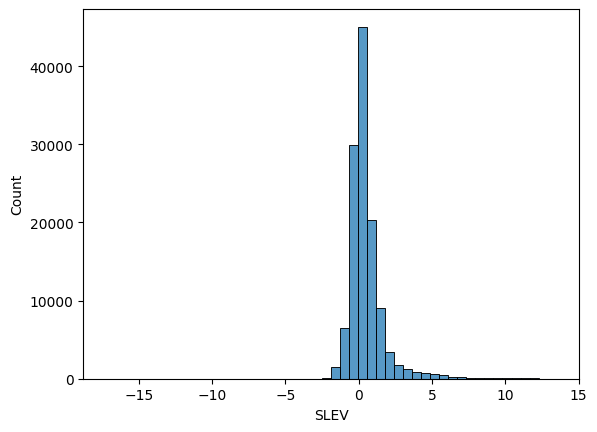

In [12]:
# make histplot 
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_marinas['SLEV'], bins=50)
plt.show()

In [16]:
df_marinas.head()

,TIME,DEPTH,TIME_QC,DEPH,LATITUDE,LONGITUDE,SLEV,SLEV_QC,VTPK,VTPK_QC,VTM02,VTM02_QC,VZMX,VZMX_QC,VHM0,VHM0_QC,DEPLOYMENT,DEPLOY_LATITUDE,DEPLOY_LONGITUDE,TEMP,TEMP_QC,STATION
0,2025-01-01 00:00:00,0.0,1.0,0.0,51.720001,4.895,0.365000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KeizersveerTG
1,2025-01-01 01:00:00,0.0,1.0,0.0,51.720001,4.895,0.305000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KeizersveerTG
2,2025-01-01 02:00:00,0.0,1.0,0.0,51.720001,4.895,0.260000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KeizersveerTG
3,2025-01-01 03:00:00,0.0,1.0,0.0,51.720001,4.895,0.280000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KeizersveerTG
4,2025-01-01 04:00:00,0.0,1.0,0.0,51.720001,4.895,0.423333,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KeizersveerTG


In [13]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

row_heights = 100

# Erstelle Subplots: Anzahl der Zeilen entspricht der Anzahl der einzigartigen Stationen
fig = make_subplots(rows=len(df_marinas['STATION'].unique()), cols=1, shared_xaxes=True, 
                    vertical_spacing=0.01, subplot_titles=None)

row = 1  # Start bei der ersten Zeile

for station in df_marinas['STATION'].unique():
    df_station = df_marinas[df_marinas['STATION'] == station]
    df_station['TIME'] = pd.to_datetime(df_station['TIME'])
    df_anomalies = df_station.copy()

    # Anomalien erkennen
    df_anomalies['anomaly'] = df_anomalies['SLEV'].apply(lambda x: 1 if x > 1.0 else 0)

    # Identifikation von Anomalien mit Z-Score > 3
    df_anomalies_grouped = df_anomalies.loc[df_anomalies['anomaly'] == 1, ['TIME', 'SLEV', 'anomaly']].groupby(by='TIME').mean().reset_index()

    # Füge Trace für Station und Anomalien hinzu
    fig.add_trace(go.Scatter(x=df_station['TIME'], y=df_station['SLEV'], mode='lines', name=str(station)),
                  row=row, col=1)

    fig.add_trace(go.Scatter(x=df_anomalies_grouped['TIME'], y=df_anomalies_grouped['SLEV'], 
                             mode='markers', name=f'Anomalies {str(station)}'),
                  row=row, col=1)

    row += 1  # Gehe zur nächsten Zeile

stations = df_marinas['STATION'].unique()
num_stations = len(stations)
# Gesamtgröße der Figur berechnen
fig.update_layout(
    height=num_stations * 500,  # Berechnete Höhe
    title_text="SLEV und Anomalien für jede Marina",
    showlegend=True,
    hovermode='x unified',
    # simple white
    template='plotly_white',
    # show x axis
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
)
fig.show()


ValueError: Vertical spacing cannot be greater than (1 / (rows - 1)) = 0.006024.
The resulting plot would have 167 rows (rows=167).

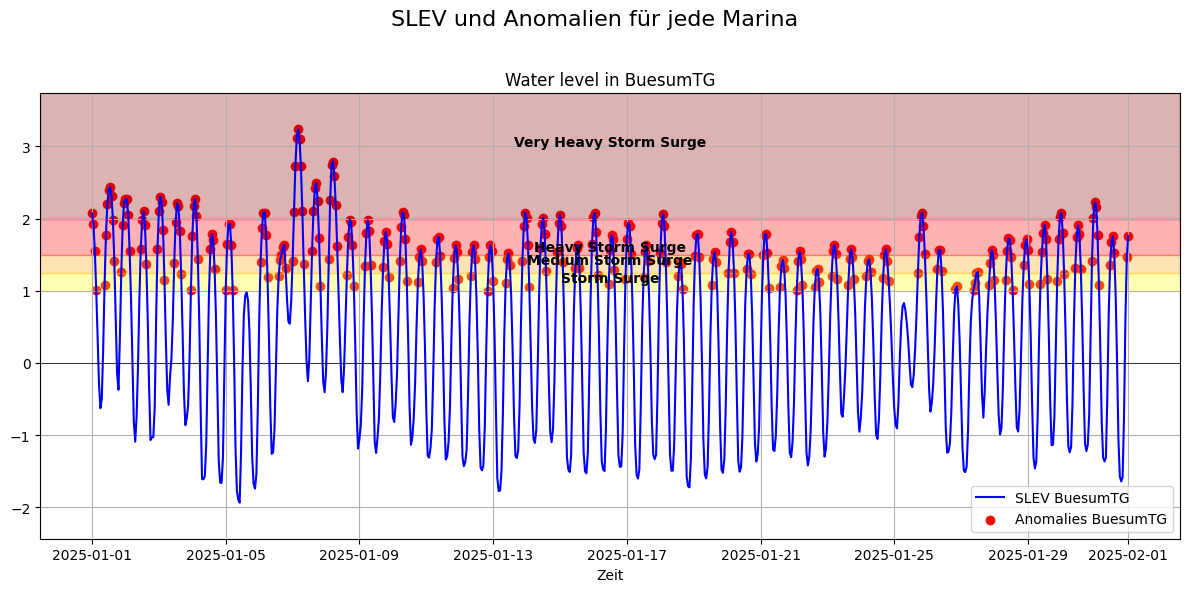

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Erstelle eine Figure mit Subplots
stations = df_marinas['STATION'].unique()
num_stations = len(stations)

fig, axes = plt.subplots(nrows=num_stations, ncols=1, figsize=(12, num_stations * 6), sharex=False)

# Bestimme globale y-Achsen-Grenzen
y_min = df_marinas['SLEV'].min() - 0.5
y_max = df_marinas['SLEV'].max() + 0.5
# Falls nur eine Station vorhanden ist, mache axes zu einer Liste
if num_stations == 1:
    axes = [axes]

for ax, station in zip(axes, stations):
    df_station = df_marinas[df_marinas['STATION'] == station]
    df_station['TIME'] = pd.to_datetime(df_station['TIME'])
    df_anomalies = df_station.copy()

    # Anomalien erkennen
    df_anomalies['anomaly'] = df_anomalies['SLEV'].apply(lambda x: 1 if x > 1.0 else 0)

    # Identifikation von Anomalien 
    df_anomalies_grouped = df_anomalies[df_anomalies['anomaly'] == 1].drop(columns=['STATION']).groupby(by='TIME').mean().reset_index()

    # Plot der normalen Werte
    ax.plot(df_station['TIME'], df_station['SLEV'], label=f'SLEV {station}', color='blue', linestyle='-')

    # Plot der Anomalien als Punkte
    ax.scatter(df_anomalies_grouped['TIME'], df_anomalies_grouped['SLEV'], color='red', label=f'Anomalies {station}')

    ax.set_title(f'Water level in {station}')
    ax.legend()
    ax.grid(True)

    # Setze die y-Achse fix für alle Subplots
    ax.set_ylim(y_min, y_max)

    # plot hirizontal line at 0
    ax.axhline(0, color='black', linewidth=0.5)

    ax.axhspan(1, 1.25, color='yellow', alpha=0.3)
    ax.axhspan(1.25, 1.5, color='orange', alpha=0.3)
    ax.axhspan(1.5, 2, color='red', alpha=0.3)
    ax.axhspan(2, 4, color='darkred', alpha=0.3)

    
    # Texte zu den Bereichen hinzufügen
    x_text_pos = df_station['TIME'].median()  # Die Mitte der x-Achse wählen
    ax.text(x_text_pos, 1.12, "Storm Surge", fontsize=10, color="black", ha="center", fontweight="bold")
    ax.text(x_text_pos, 1.37, "Medium Storm Surge", fontsize=10, color="black", ha="center", fontweight="bold")
    ax.text(x_text_pos, 1.55, "Heavy Storm Surge", fontsize=10, color="black", ha="center", fontweight="bold")
    ax.text(x_text_pos, 3, "Very Heavy Storm Surge", fontsize=10, color="black", ha="center", fontweight="bold")


# Gemeinsame X-Achse für alle Subplots
plt.xlabel("Zeit")
plt.suptitle("SLEV und Anomalien für jede Marina", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Platz für den Suptitel lassen
plt.show()